<a href="https://colab.research.google.com/github/quotation3/DB_Finance/blob/main/Topic_Modeling/5_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### mecab 설치후 Tokenize

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
text = u"""이제 구글 코랩에서 Mecab-ko라이브러리 사용이 가능합니다. 읽어주셔서 감사합니다."""
nouns = mecab.nouns(text)
print(nouns)

['구글', '코', '랩', '라이브러리', '사용', '가능', '감사']


In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
text = "이제 구글 코랩에서 Mecab-ko라이브러리 사용이 가능합니다. 읽어주셔서 감사합니다."
a = mecab.pos(text)
print(a)

[('이제', 'MAG'), ('구글', 'NNG'), ('코', 'NNG'), ('랩', 'NNG'), ('에서', 'JKB'), ('Mecab', 'SL'), ('-', 'SY'), ('ko', 'SL'), ('라이브러리', 'NNG'), ('사용', 'NNG'), ('이', 'JKS'), ('가능', 'NNG'), ('합니다', 'XSA+EF'), ('.', 'SF'), ('읽', 'VV'), ('어', 'EC'), ('주', 'VX'), ('셔서', 'EP+EC'), ('감사', 'NNG'), ('합니다', 'XSV+EF'), ('.', 'SF')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
news = pd.read_csv('/content/drive/MyDrive/DB_Finance/data/peak_change.csv')
news.head()

,date,text,media,price,volume,change
0,2017-01-02,"中, 한국산 배터리 탑재차 보조금 제외…LG화학·삼성SDI '날벼락'(서울=뉴스1)...",뉴스1,253000,294947,-3.07
1,2017-01-02,[리더십 4.0시대]2016년 1년간 분석한 '4차 산업혁명' 리더 경영인은 누굴까...,서울경제,253000,294947,-3.07
2,2017-01-02,"구본무 회장, ""창립 70년 맞은 올해 새롭게 시작하자""[머니투데이 오동희 기자] ...",머니투데이,253000,294947,-3.07
3,2017-01-02,개미들 한미약품 몰빵했다 '쪽박'…손실 무려 -57.75%코스피 개인 순매수 상위 ...,연합뉴스,253000,294947,-3.07
4,2017-01-02,"[로봇뉴스]아모레퍼시픽_주요 매물구간인 354,000원선이 저항대로 작용",전자신문,253000,294947,-3.07


In [ ]:
news['nouns']=''

In [ ]:
for i in range(len(news)):
    try:
        news['nouns'][i] = mecab.nouns(news['text'][i])
    except:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
news.head()

,date,text,media,price,volume,change,nouns
0,2017-01-02,"中, 한국산 배터리 탑재차 보조금 제외…LG화학·삼성SDI '날벼락'(서울=뉴스1)...",뉴스1,253000,294947,-3.07,"[中, 한국, 배터리, 탑, 보조금, 제외, 화학, 삼성, 날벼락, 서울, 뉴스, ..."
1,2017-01-02,[리더십 4.0시대]2016년 1년간 분석한 '4차 산업혁명' 리더 경영인은 누굴까...,서울경제,253000,294947,-3.07,"[리더십, 시대, 년, 년, 간, 분석, 차, 산업, 혁명, 리더, 경영인, 누굴까..."
2,2017-01-02,"구본무 회장, ""창립 70년 맞은 올해 새롭게 시작하자""[머니투데이 오동희 기자] ...",머니투데이,253000,294947,-3.07,"[구본무, 회장, 창립, 년, 올해, 시작, 머니, 투데이, 오동희, 기자, 회장,..."
3,2017-01-02,개미들 한미약품 몰빵했다 '쪽박'…손실 무려 -57.75%코스피 개인 순매수 상위 ...,연합뉴스,253000,294947,-3.07,"[개미, 한미, 약품, 빵, 쪽박, 손실, 무려, 코스피, 개인, 매수, 상위, 종..."
4,2017-01-02,"[로봇뉴스]아모레퍼시픽_주요 매물구간인 354,000원선이 저항대로 작용",전자신문,253000,294947,-3.07,"[로봇, 뉴스, 아모레, 퍼시픽, 주요, 매물, 구간, 원선, 저항, 작용]"


### 주식 시황에 관련된 주가 뉴스는 제거

In [ ]:
stop_words = ['코스피', '지수','코스닥','매수','매도','증권','부고']

In [ ]:
# stop_words 들어간 기사 확인
lis = []
for i in range(len(news)):
    for j in stop_words:
        if j in news['nouns'][i]:
            lis.append(i)

In [ ]:
len(set(lis))

4381

In [ ]:
# stop_words 들어간 기사 제거
real = news.drop(lis)[['date','text','nouns']]

In [ ]:
real.head()

,date,text,nouns
0,2017-01-02,"中, 한국산 배터리 탑재차 보조금 제외…LG화학·삼성SDI '날벼락'(서울=뉴스1)...","[中, 한국, 배터리, 탑, 보조금, 제외, 화학, 삼성, 날벼락, 서울, 뉴스, ..."
1,2017-01-02,[리더십 4.0시대]2016년 1년간 분석한 '4차 산업혁명' 리더 경영인은 누굴까...,"[리더십, 시대, 년, 년, 간, 분석, 차, 산업, 혁명, 리더, 경영인, 누굴까..."
2,2017-01-02,"구본무 회장, ""창립 70년 맞은 올해 새롭게 시작하자""[머니투데이 오동희 기자] ...","[구본무, 회장, 창립, 년, 올해, 시작, 머니, 투데이, 오동희, 기자, 회장,..."
4,2017-01-02,"[로봇뉴스]아모레퍼시픽_주요 매물구간인 354,000원선이 저항대로 작용","[로봇, 뉴스, 아모레, 퍼시픽, 주요, 매물, 구간, 원선, 저항, 작용]"
5,2017-01-02,한국산 ‘車 배터리’ 中서 설 자리 잃나…장착 차량 보조금도 제외[헤럴드경제=유재훈...,"[한국, 車, 배터리, 中, 설, 자리, 장착, 차량, 보조금, 제외, 헤럴드, 경..."


In [ ]:
real = real[(real['date']>'2016-12-31')&(real['date']<'2017-07-01')]

### LDA토픽모델링

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import CoherenceModel
from gensim import corpora, models
import gensim

In [ ]:
# 한글자 짜리 명사 제거
data =real['nouns']
data = [[y for y in x if not len(x)==1]
       for x in data]

In [ ]:
noun = real['nouns']
data = []
for i in noun:
    tmp = []
    for x in i:
        if len(x) != 1:
            tmp.append(x)
    data.append(tmp)

In [ ]:
dictionary= corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

In [ ]:
co = []
pe =[]
for i in tqdm(range(5, 60, 5)):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    co_model_lda = CoherenceModel(model=ldamodel, texts=data, dictionary=dictionary, topn=10)
    coherence_lda=co_model_lda.get_coherence()
    co.append(coherence_lda)
    pe.append(ldamodel.log_perplexity(corpus))

In [ ]:
print(co)
print(pe)

[0.4402897933366858, 0.43519143731061927, 0.4585615263133173, 0.4371918840836303, 0.42694847118648144, 0.44654035932340036, 0.4390904449399685, 0.44855771489381696, 0.4340636317185484, 0.45108027765935477, 0.44450511096964296]
[-7.870615193892488, -8.136937292099242, -8.38994953661586, -8.624731210111348, -8.887616487306497, -9.113619306337942, -9.316336803202448, -9.553200945005116, -9.753192517327705, -9.887269040867416, -10.07062105199295]


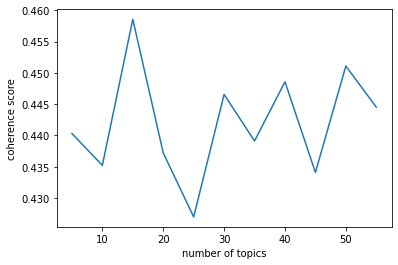

In [ ]:
x = range(5, 60, 5)
plt.plot(x, co)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

In [ ]:
len(dictionary)

8552

In [ ]:
import gensim
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.011*"시장" + 0.009*"기업" + 0.009*"바이오" + 0.008*"산업"')
(1, '0.060*"중국" + 0.024*"한국" + 0.024*"사드" + 0.018*"배터리"')
(2, '0.017*"기술" + 0.017*"주행" + 0.016*"자율" + 0.011*"전자"')
(3, '0.018*"시장" + 0.013*"중국" + 0.013*"제약" + 0.011*"국내"')
(4, '0.041*"에너지" + 0.010*"사업" + 0.009*"전력" + 0.009*"화학"')
(5, '0.049*"배터리" + 0.024*"전기차" + 0.024*"공장" + 0.018*"생산"')
(6, '0.020*"미국" + 0.019*"화학" + 0.015*"한국" + 0.013*"수출"')
(7, '0.021*"화학" + 0.009*"회사" + 0.008*"기업" + 0.008*"기자"')
(8, '0.025*"전기차" + 0.025*"주행" + 0.020*"전기" + 0.020*"볼트"')
(9, '0.020*"벤처" + 0.018*"소셜" + 0.018*"사회" + 0.013*"기업"')
(10, '0.015*"나노" + 0.014*"시장" + 0.012*"한국" + 0.011*"기술"')
(11, '0.048*"기업" + 0.022*"산업" + 0.011*"국내" + 0.010*"출원"')
(12, '0.012*"장애" + 0.011*"공장" + 0.010*"중국" + 0.008*"화학"')
(13, '0.035*"화학" + 0.023*"영업" + 0.023*"분기" + 0.022*"이익"')
(14, '0.030*"사업" + 0.027*"회장" + 0.025*"부회장" + 0.023*"경영"')


In [ ]:
pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
pyLDAvis.save_html(vis, '/content/drive/MyDrive/DB_Finance/data/topic/output/topic_2017_first.html')